# Optimization problem
we would like to maximise 
$$
\operatorname{\mathbb{E}_{t}}[R_{t}^{P}] - \gamma \operatorname{Var_{t}}[R_{t}^{P}]
$$
with respect to $z_{t}$, under the contraint that $\mathbb{1}^{T}z_{t}=0$. Here, $\gamma$, a _risk aversion parameter_ , with value $\gamma = 1/2$.

In addition, we would like to add the no short-sale constraint 
$$
w_{t}+z_{t} \geq 0.
$$ 

Hence, we would like to pick the $z_{t}$ that solves the optimization problem
$$
\begin{equation}
\begin{aligned}
& \underset{z_{t}\in\mathbb{R}^{n}}{\mathrm{maximize}}
& & R_{t|t}^{T}z_{t} - \gamma (w_{t}+z_{t})^{T}\Sigma_{t|t}(w_{t}+z_{t}) \\
& \text{subject to}
& &  \mathbb{1}^{T}z_{t}=0, \\
& & &  w_{t}+z_{t} \geq 0, \\
\end{aligned}
\end{equation}
$$

for each time $t=1\ldots,T$. However, $R_{t|t}$ and $\Sigma_{t|t}$ are typically not know, but can be replaced by approprate estimates $\hat R_{t|t}$ and $\hat\Sigma_{t|t}$, respectively. Thus, we arrive at the final problem 
$$
\begin{equation}
\begin{aligned}
& \underset{z_{t}\in\mathbb{R}^{n}}{\mathrm{maximize}}
& & \hat R_{t|t}^{T}z_{t} - \gamma (w_{t}+z_{t})^{T}\hat\Sigma_{t|t}(w_{t}+z_{t}) \\
& \text{subject to}
& &  \mathbb{1}^{T}z_{t}=0, \\
& & &  w_{t}+z_{t} \geq 0, \\
\end{aligned}
\end{equation}
$$
that needs to be solved for each time $t=1\ldots,T$.


In [3]:
import os
import numpy as np
import pandas as pd
import pickle

os.chdir(os.path.pardir)
%cd Data
import investPyData as omxs30
Rpd, N = omxs30.import_omxs30() # N number of stocks, R return between two days


T = len(Rpd)
R=Rpd.to_numpy()
print(T/252)

/Users/manssandsjo/Documents/GitHub/StockBot/group-b/src/Data
1.9404761904761905


In [4]:
import cvxpy as cvx
import mosek

def SPO_mark(hat_R, hat_Sigma, weights, gamma):
    z = cvx.Variable(N)
    expected_netReturn = hat_R.T @ z # for each stock, depends on how 
    expected_risk = gamma*cvx.quad_form(weights + z, hat_Sigma) # weights.T * hat_Sigma * weights
    
    utility = expected_netReturn - expected_risk
    objective = cvx.Maximize(utility)

    constraints = [
        cvx.sum(z) == 0, # difference in weights sums up to 0 – portfolio stays fully invested
        weights + z >= 0, # no short sales
        weights + z <= 0.3 # no more than 30% in an asset
    ] 
    prob = cvx.Problem(objective, constraints)
    prob.solve(solver=cvx.MOSEK)
    
    return z.value #change of weights

## Function to loop convex optimization for each day of the period

In [5]:
def loop_optimization(calc_mu, Sigma_func, SigmaHyper, gamma):
    totValue = np.empty(T+1)
    totValue[0] = 1E6
    weights = np.ones(N)/N # starting with 1/30 invested in all stocks
    R_P = np.zeros(T) # portfolio realized return - fractional increase of portfolio return over the period
    muTemp = R[0,:] # use the old mu value the first period of optimization & when not predicting return
    sigma = Sigma_func(1, SigmaHyper)
    
    z = SPO_mark(muTemp, sigma, weights, gamma)# tSigma_func is the cov matrix of the expected returns
    R_P[0] = R[0].T @ (weights + z)
    totValue[1] = totValue[0] * (1 + R_P[0]) # total value of the whole portfolio
    turnover = np.linalg.norm(z,ord=1)/2
    
    # Iterate over the whole period T and calculate the change of weights by maximazing
    # the risk adjusted return of each period
    for t in range (T-1):
        
        muTemp = calc_mu[t,:]
        #estimate the cov matrix for day t
        sigma = Sigma_func(t, SigmaHyper)
        # solve the convex optimization problem for each day
        weights =  (1 + R[t])*(weights + z) / (1+R_P[t]) # next period weights Boyd (2.11)
        z = SPO_mark(muTemp, sigma, weights, gamma) #c

        turnover += np.linalg.norm(z ,ord=1)/2
        R_P[t+1] = R[t+1].T @ (weights + z) # calc the actual return from the new calc weights
        totValue[t+2] = totValue[t+1] * (1 + R_P[t+1])
    return totValue, turnover, R_P, weights

# Performance metrics
Annualized average turnover is calculated by:
$$
\begin{equation}
\frac{250}{T} \sum_{t=1}^{T}\left\|\left(z_{t}\right)_{1: n}\right\|_{1} / 2
\end{equation}
$$

The _post-trade total value_ of the portfolio, in SEK, given exactly at the beginning of time period $t$, is just $v_{t}$, since
$$
\mathbb{1}^{T}h_{t}^{+} = \mathbb{1}^{T}(h_{t} + u_{t}) = \mathbb{1}^{T}h_{t} + \mathbb{1}^{T} u_{t} = \mathbb{1}^{T}h_{t} = v_{t}, \quad \forall t = 1,\ldots,T.
$$

Assuming that the risk-free rate is zero, the annualized sharpe ratio is given by:
$$
SR = \frac{\overline{R^{P}_{t}}}{\widehat{\sigma}^{P}}.
$$

In [6]:
# function to plot and print the portfolio data
from matplotlib import pyplot as plt

def plot_n_printPortfolio(totValuePrint, turnoverPrint, R_Pprint, name, weightsPrint):
    an_turnover = (turnoverPrint/T)*252 # approx 252 trading days in a year

    print('\033[1m'+name+'\033[0m')
    print('Turnover:',an_turnover.round(6)); print('Total value of portfolio:', totValuePrint[T].round())
    
    #plot the total value of the portfolio over time T
    fig, axes = plt.subplots()
    years = np.arange(T+1)/252
    axes.plot(years, totValuePrint)
    axes.set_xlabel('Year')
    axes.set_ylabel('SEK')
    axes.set_title(name);


    # print the sharpe ratio
    # annualized average of returns
    averageRe = np.mean(R_Pprint)*252
    # annualized standard deviation of returns
    stdSigma = np.std(R_Pprint)*np.sqrt(252)
    sharpeRatio_an = (averageRe/stdSigma)
    print('Sharpe Ratio:', sharpeRatio_an.round(6)); print('Weights at end of period', weightsPrint.round(4))

In [7]:
def hyperMetrics(totValuePrint, turnoverPrint, R_Pprint):
    an_turnover = (turnoverPrint/T)*252 # approx 252 trading days in a year

    # annualized average of returns
    averageRe = np.mean(R_Pprint)*252
    # annualized standard deviation of returns
    stdSigma = np.std(R_Pprint)*np.sqrt(252)
    sharpeRatio_an = (averageRe/stdSigma)
    return an_turnover, sharpeRatio_an

## Simple Covariance Matrix

In [8]:
def covariance_calc_v1(t, T_SCM):
    R_Sigma = R.copy()
    Sigma = np.zeros((N,N))
    
    if t-T_SCM < 0:
            Sigma = np.dot(R_Sigma[t-1].reshape((N,1)),R_Sigma[t-1].reshape((1,N)))
            return Sigma
    
    for i in range (t-T_SCM,t):
        
        Sigma += np.dot(R_Sigma[i].reshape((N,1)),R_Sigma[i].reshape((1,N)))
    Sigma = Sigma/T_SCM
    return Sigma

## Ledoit & Wolf

In [9]:
#Manu föreslår assume_centered = True, tveksamt om det funkar som intended dock
#DENNA KÖR PÅ HELA INTERVALLET OCH TAR EJ HÄNSYN TILL span, span används för att sätta assume centered eller ej
def Ledoit_Wolf(t,ass_centered):
    R_Sigma = R.copy()
    from sklearn.covariance import LedoitWolf  
    
    if t <= 5:
        Sigma = np.dot(R_Sigma[t-1].reshape((N,1)),R_Sigma[t-1].reshape((1,N)))
        return Sigma
        
    cov = LedoitWolf(assume_centered=ass_centered).fit(R_Sigma[0:t-1,:])

    return cov.covariance_


## Simple moving average
$ SMA = \frac{A^n_1+A^n_2+...+A^n_t}{T}$
<br>Where $A^n_t =$ the return of the stock $n$ at period $t$
<br> $T =$ number of periods


In [10]:
def calcSMA(Tsma):
    df_Rsma = Rpd.copy()

    for col in Rpd.columns:
        # to calculate first Tsma periods set min_periods = 1
        # for instance the 2nd day then becomes the first days real value, 3rd day mean of 1st and 2nd real returns
        df_Rsma[col] = Rpd[col].shift(1).rolling(Tsma, min_periods = 1).mean() # shift 1 to calc from yesterdays values
    df_Rsma = df_Rsma.iloc[1:]
    return df_Rsma.to_numpy()


## Exponential Moving Average
Exponential moving average gives more weight to the recent prices and as a result of which, it can be a better model or better capture the movement of the trend in a faster way. EMA's reaction is directly proportional to the pattern of the data.

Let $\alpha_{\text{EMA}}\in (0,1)$ and
$$
\begin{align}
    \hat R_{t|t}^{\text{EMA}} = 
    \begin{cases}
    R_{t-1},              & \text{if } t = 2, \\
    \alpha_{\text{EMA}} \hat R_{t-1|t-1}^{\text{EMA}} + (1 - \alpha_{\text{EMA}}) R_{t-1},              & \text{if } 2 < t \leq T.
    \end{cases}
\end{align}
$$
Often, a variable $\tau_{\text{EMA}}\in\mathbb{N}$ is introduced such that 
$$
\begin{align*}
    \alpha_{\text{EMA}} = 1 - \frac{1}{\tau_{\text{EMA}} + 1},
\end{align*}
$$

In [11]:
def calcEMA(span):
    df_Rema = Rpd.copy()
    for index in df_Rema.index[:T-1]:
        if index <= 2:
            df_Rema.iloc[index] = Rpd.iloc[index-1]
        else:
            df_Rema.iloc[index] = df_Rema.iloc[index-1].ewm(span=span,adjust=False).mean()
            R_ewm = df_Rema.to_numpy()
            
    return R_ewm

## Hyper optimization for SMA & SCM
between 2010-2018

In [ ]:

hyperDataFrameSMA = pd.DataFrame(columns=['Tsma','SigmaHyper','Gamma','Turnover','SharpeRatio'])

for Tsma in np.logspace(1,5,num =4, base=2, dtype='int'):
    print('TSma', Tsma)
    for SigmaHyper in np.logspace(1,4,num =4, base=2, dtype='int'):
        print('SigmaHyper', SigmaHyper)
        for gamma in np.logspace(-1,11,num =7, base=2, dtype='float'): 
            totValueSMA, turnoverSMA, R_Psma, weightsSMA = loop_optimization(
                calcSMA(Tsma), 
                covariance_calc_v1, 
                SigmaHyper,
                gamma)
            turnOver, sharpeR = hyperMetrics(totValueSMA, turnoverSMA, R_Psma)
            hyperDataFrameSMA = hyperDataFrameSMA.append({'Tsma': Tsma, 'SigmaHyper': SigmaHyper, 'Gamma': gamma, 'Turnover': turnOver,'SharpeRatio': sharpeR}, ignore_index=True)

hyperDataFrameSMA.head(100)
hyperDataFrameSMA.to_pickle('./pickle_hyper/hyperDataFrameSMA_SCM.pkl')

In [17]:
opSMApd = pd.read_pickle('./pickle_hyper/hyperDataFrameSMA_SCM.pkl')
hyperDataSMAsort = opSMApd[(opSMApd['SharpeRatio'] > 0) ]
hyperDataSMAsort

,Tsma,SigmaHyper,Gamma,Turnover,SharpeRatio
3,2.0,2.0,32.0,167.195557,0.006936
75,12.0,8.0,512.0,90.786767,0.045875
76,12.0,8.0,2048.0,87.619191,0.021370
102,32.0,8.0,128.0,75.558386,0.010463
103,32.0,8.0,512.0,82.137790,0.102309
104,32.0,8.0,2048.0,84.525233,0.118529


## Hyper optimization for EMA and SCM
between 2010-2018

In [ ]:
hyperDataFrameEMA = pd.DataFrame(columns=['T_ema','SigmaHyper','Gamma','Turnover','SharpeRatio'])

for T_ema in np.logspace(3,8, num =5, base=2, dtype='int'):
    print('T_ema', T_ema)
    for SigmaHyper in np.logspace(1,4,num =4, base=2, dtype='int'):
        print('SigmaHyper', SigmaHyper)
        for gamma in np.logspace(-1,11,num =7, base=2, dtype='float'): 
            totValueEMA, turnoverEMA, R_Pema, weightsEMA = loop_optimization(
                calcEMA(T_ema), 
                covariance_calc_v1, 
                SigmaHyper,
                gamma)
            turnOver, sharpeR = hyperMetrics(totValueEMA, turnoverEMA, R_Pema)
            hyperDataFrameEMA = hyperDataFrameEMA.append({'T_ema': T_ema, 'SigmaHyper': SigmaHyper, 'Gamma': gamma, 
                                                          'Turnover': turnOver,'SharpeRatio': sharpeR}, ignore_index=True)

hyperDataFrameEMA.to_pickle('./pickle_hyper/hyperDataFrameEMA_SCM.pkl')

In [ ]:
opEMApd = pd.read_pickle('./pickle_hyper/hyperDataFrameEMA_SCM.pkl')
hyperDataEMAsort = opEMApd[(opEMApd['SharpeRatio'] > 0) & (opEMApd['Turnover'] < 82 )]
opEMApd.head(30)

## Hyper Optimization SMA & LW

In [ ]:
hyperDataFrameSMA_LW = pd.DataFrame(columns=['TSma','SigmaHyper','Gamma','Turnover','SharpeRatio'])

for TSma in np.logspace(3,8,num =4, base=2, dtype='int'): #4
    print('TSma', TSma)
    for SigmaHyper in range(0,2):
        print('SigmaHyper', SigmaHyper)
        if(SigmaHyper == 0):
            SigmaHyper = False
        if(SigmaHyper == 1):
            SigmaHyper = True
        for gamma in np.logspace(-1,11,num =7, base=2, dtype='float'): #7
            totValueSMA, turnoverSMA, R_Psma, weightsSMA = loop_optimization(
                calcSMA(TSma), 
                Ledoit_Wolf, 
                SigmaHyper,
                gamma)
            turnOver, sharpeR = hyperMetrics(totValueSMA, turnoverSMA, R_Psma)
            hyperDataFrameSMA_LW = hyperDataFrameSMA_LW.append({'TSma': TSma, 'SigmaHyper': SigmaHyper, 'Gamma': gamma, 'Turnover': turnOver,'SharpeRatio': sharpeR}, ignore_index=True)

hyperDataFrameSMA_LW.head()

## Hyper Optimization EMA & LW

In [ ]:
#EMA_LW

hyperDataFrameEMA_LW = pd.DataFrame(columns=['Tema','SigmaHyper','Gamma','Turnover','SharpeRatio'])

for Tema in np.logspace(3,8,num =4, base=2, dtype='int'): #4
    print('Tema', Tema)
    for SigmaHyper in range(0,2):
        print('SigmaHyper', SigmaHyper)
        if(SigmaHyper == 0):
            SigmaHyper = False
        if(SigmaHyper == 1):
            SigmaHyper = True
        for gamma in np.logspace(-1,11,num =7, base=2, dtype='float'): #7
            totValueEMA, turnoverEMA, R_Pema, weightsEMA = loop_optimization(
                calcEMA(Tema), 
                Ledoit_Wolf, 
                SigmaHyper,
                gamma)
            turnOver, sharpeR = hyperMetrics(totValueEMA, turnoverEMA, R_Pema)
            hyperDataFrameEMA_LW = hyperDataFrameEMA_LW.append({'Tema': Tema, 'SigmaHyper': SigmaHyper, 'Gamma': gamma, 'Turnover': turnOver,'SharpeRatio': sharpeR}, ignore_index=True)

hyperDataFrameEMA_LW.head()

## LSTM
LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. 

In [ ]:
def predictLSTM(model, stock, iterDays, sc):
# vill uppdatera LSTM datan ofta för att få bra prediktion typ rullande varje dag
    #trYrs = len(R)-30;
    
    # make predictions 1 day at a time
    predDays = 1
    #day_of_pred = trYrs+iterDays
    # retrieve last observations for input data and feed with known days continously
    inputs = stock
    # reshape into [1, input, 1]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)
    inputs = inputs.reshape((1,len(inputs),1))
    #print(inputs)
    
    '''
    X_test = []  

    # predict next 5 days
    for i in range(predDays,len(inputs)):
        X_test.append(inputs[i-predDays:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    print(np.shape(X_test))'''


    rets_pred = model.predict(inputs,verbose=1) 

    rets_pred = sc.inverse_transform(rets_pred)


    
    return rets_pred

vill uppdatera LSTM datan ofta för att få bra prediktion typ rullande varje dag

Run data and create models for each of the stocks

ändra successivt historiken av data som matas till predictLSTM med 1 dag

In [ ]:
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
# glöm inte ändra investpy range från 2016-2018
# load LSTM models from Data/keras_models
os.chdir(os.path.pardir)
%cd Data

ndaysPred = len(R)
dfLSTM = pd.DataFrame(np.zeros((ndaysPred, N)))
predValue = 0

# loop over the stocks denna tar typ 20-30 min för alla stocks
for stock in range (N):
    # load saved model for stock
    model = keras.models.load_model('keras_models/model_2010_2016_'+str(stock))
    # load saved scaler
    sc = pickle.load(open('scaler.pkl'+str(stock),'rb'))
    print(stock) # to see progress
    
    #create prediction for ndaysPred for that stock
    for day in range (1,ndaysPred): 
        # save historical data for model as previous day
        stockHist = Rpd.iloc[day-1,stock]
        # predict next day's return
        predValue = predictLSTM(model, stockHist, day, sc)
        # save to R_hat vect
        dfLSTM.iloc[day,stock] = predValue
        
dfLSTM.to_pickle('./pickle_hyper/R_lstm_2018_2020.pkl')

In [ ]:
totValueSMA, turnoverSMA, R_Psma, weightsSMA = loop_optimization(dfR_LSTM.to_numpy(), covariance_calc_v1)
#print(R_Psma)
plot_n_printPortfolio(totValueSMA, turnoverSMA, R_Psma, 'LSTM Predicted Portfolio')

## Hyper Optimization LSTM & SCM

In [ ]:
# Viewing the LSTM model as fixed, since we don't have the required computing power 
# to hyper optimize the parameters for LSTM
R_LSTM = pd.read_pickle('./pickle_hyper/R_lstm_2016_2018.pkl').to_numpy()

hyperDataFrameLSTM_SCM = pd.DataFrame(columns=['T_SCM','Gamma','Turnover','SharpeRatio'])

for SigmaHyper in np.logspace(1,4,num =4, base=2, dtype='int'):
    print('SigmaHyper', SigmaHyper)
    for gamma in np.logspace(-1,11,num =7, base=2, dtype='float'): #7
        totValueSMA, turnoverSMA, R_Psma, weightsSMA = loop_optimization(
            R_LSTM, 
            covariance_calc_v1, 
            SigmaHyper,
            gamma)
        turnOver, sharpeR = hyperMetrics(totValueSMA, turnoverSMA, R_Psma)
        hyperDataFrameLSTM_SCM = hyperDataFrameLSTM_SCM.append({'T_SCM': SigmaHyper, 'Gamma': gamma, 'Turnover': turnOver,'SharpeRatio': sharpeR}, ignore_index=True)

hyperDataFrameLSTM_SCM.to_pickle('./pickle_hyper/hyperDataFrameLSTM_SCM.pkl')

In [ ]:
opLSTM_SCMpd = pd.read_pickle('./pickle_hyper/hyperDataFrameLSTM_SCM.pkl')
hyperDataLSTM_SCMsort = opLSTM_SCMpd[(opLSTM_SCMpd['SharpeRatio'] > 0) & (opLSTM_SCMpd['Turnover'] < 82 )]
hyperDataLSTM_SCMsort


## Hyper optimization LSTM & LW

In [ ]:
# Viewing the LSTM model as fixed, since we don't have the required computing power 
# to hyper optimize the parameters for LSTM
R_LSTM = pd.read_pickle('./pickle_hyper/R_lstm_2016_2018.pkl').to_numpy()

hyperDataFrameLSTM_LW = pd.DataFrame(columns=['SigmaHyper','Gamma','Turnover','SharpeRatio'])

for SigmaHyper in range(0,2):
    print('SigmaHyper', SigmaHyper)
    if(SigmaHyper == 0):
        SigmaHyper = False
    if(SigmaHyper == 1):
        SigmaHyper = True
    for gamma in np.logspace(-1,11,num =7, base=2, dtype='float'): #7
        totValueSMA, turnoverSMA, R_Psma, weightsSMA = loop_optimization(
                R_LSTM, 
                Ledoit_Wolf, 
                SigmaHyper,
                gamma)
        turnOver, sharpeR = hyperMetrics(totValueSMA, turnoverSMA, R_Psma)
        hyperDataFrameLSTM_LW = hyperDataFrameLSTM_LW.append({'SigmaHyper': SigmaHyper, 'Gamma': gamma, 'Turnover': turnOver,'SharpeRatio': sharpeR}, ignore_index=True)


hyperDataFrameLSTM_LW.to_pickle('./pickle_hyper/hyperDataFrameLSTM_LW.pkl')

In [ ]:
opLSTM_LWpd = pd.read_pickle('./pickle_hyper/hyperDataFrameLSTM_LW.pkl')
hyperDataLSTM_LWsort = opLSTM_LWpd[(opLSTM_LWpd['SharpeRatio'] > -0.55)]
hyperDataLSTM_LWsort


## Validation of selected hyperparameters
### SMA & SCM
Best performance 2010-2018 for T_SMA = 32.0, T_SCM = 8.0, Gamma = 512.0	
gave turnover = 82.137790,	SR = 0.102309

In [12]:
# weird bug with R vector. Only for this computer
# Has a value of 9 when using date 2018-2020, replace this value with the value from day before

Rpd.iloc[311,-4] = Rpd.iloc[310,-4]

SMA & SCM Predicted Portfolio
Turnover: 81.214336
Total value of portfolio: 882678.0
Sharpe Ratio: -0.331464
Weights at end of period [0.     0.0813 0.     0.     0.     0.     0.1428 0.     0.1222 0.
 0.2991 0.0416 0.     0.     0.0583 0.     0.     0.0849 0.     0.0604
 0.     0.     0.     0.     0.     0.0839 0.     0.0256]


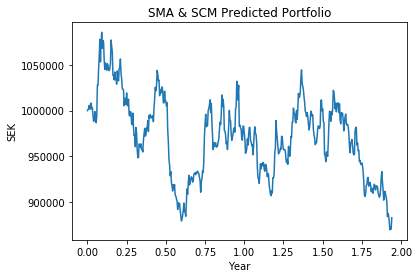

In [13]:
totValueSMA_SCM, turnoverSMA_SCM, R_Psma_scm, w = loop_optimization(calcSMA(32),covariance_calc_v1, 8, 512)

plot_n_printPortfolio(totValueSMA_SCM, turnoverSMA_SCM, R_Psma_scm, 'SMA & SCM Predicted Portfolio', w)

### EMA & SCM
Best performance from 2010-2018 for T_ema = 8.0,	T_scm = 8.0, Gamma = 2.0	
gave turnover = 81.548874, SR = 0.315238

EMA & SCM Predicted Portfolio
Turnover: 81.978917
Total value of portfolio: 1046026.0
Sharpe Ratio: 0.225031
Weights at end of period [0.003  0.2054 0.002  0.0007 0.0006 0.0007 0.0027 0.0034 0.1287 0.0009
 0.2974 0.0336 0.0006 0.0005 0.0966 0.0005 0.0005 0.0011 0.0003 0.0009
 0.0006 0.001  0.001  0.0005 0.0035 0.1189 0.0009 0.0935]


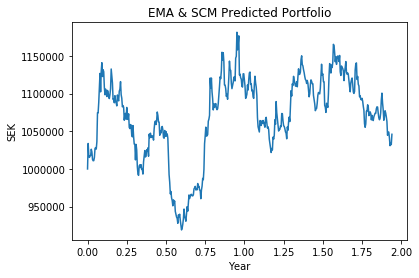

In [14]:
totValueEMA_SCM, turnoverEMA_SCM, R_Pema_scm, w = loop_optimization(calcEMA(8),
                                                                 covariance_calc_v1,
                                                                 SigmaHyper = 8,
                                                                 gamma = 2)

plot_n_printPortfolio(totValueEMA_SCM, turnoverEMA_SCM, R_Pema_scm, 'EMA & SCM Predicted Portfolio',w)

### SMA & LW

SMA & LW Predicted Portfolio
Turnover: 14.517943
Total value of portfolio: 910052.0
Sharpe Ratio: -0.087018
Weights at end of period [0.     0.     0.     0.     0.     0.     0.0093 0.     0.     0.
 0.0134 0.2995 0.     0.1996 0.0409 0.0611 0.     0.     0.0634 0.0093
 0.     0.     0.0447 0.1965 0.     0.     0.0622 0.    ]


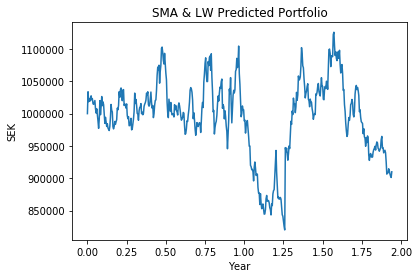

In [18]:
totValueSMA_LW, turnover, R_P, weights = loop_optimization(calcSMA(256), Ledoit_Wolf,True,2)
plot_n_printPortfolio(totValue, turnover, R_P, 'SMA & LW Predicted Portfolio', weights)

### EMA & LW

EMA & LW Predicted Portfolio
Turnover: 6.210015
Total value of portfolio: 1064537.0
Sharpe Ratio: 0.304423
Weights at end of period [1.000e-03 4.000e-04 1.117e-01 1.627e-01 1.000e-04 1.000e-04 6.000e-04
 2.500e-03 2.150e-02 9.800e-03 4.340e-02 1.570e-02 6.000e-04 7.000e-04
 1.000e-04 2.190e-02 1.000e-04 8.000e-04 3.670e-02 1.126e-01 2.100e-02
 1.000e-04 9.110e-02 4.080e-02 7.180e-02 7.810e-02 1.540e-01 1.000e-04]


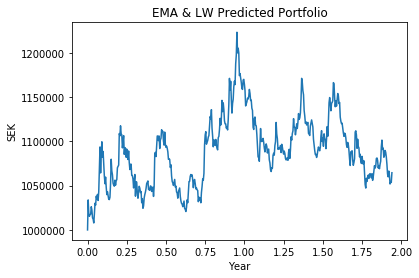

In [21]:
# optimal parameters test run from 2018-2020

totValue, turnover, R_P, weights = loop_optimization(calcEMA(8), Ledoit_Wolf,True,0.5)
plot_n_printPortfolio(totValue, turnover, R_P, 'EMA & LW Predicted Portfolio', weights)

### LSTM & SCM
Best performance from 2016-2018 for T_scm = 8.0, Gamma = 512.0,
    gave turnover = 67.623572, SR = 0.285660

LSTM & SCM Predicted Portfolio
Turnover: 67.424841
Total value of portfolio: 1111156.0
Sharpe Ratio: 0.433781
Weights at end of period [0.     0.2408 0.     0.0235 0.     0.     0.     0.     0.1181 0.
 0.2986 0.     0.     0.     0.0327 0.     0.     0.0688 0.     0.
 0.     0.     0.1971 0.     0.     0.0203 0.     0.    ]


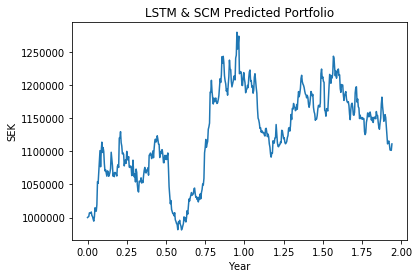

In [16]:
R_lstm2018_20 = pd.read_pickle('./pickle_hyper/R_lstm_2018_2020.pkl').to_numpy()

totValueLSTM_SCM, turnoverLSTM_SCM, R_Plstm_scm, w = loop_optimization(R_lstm2018_20,
                                                                 covariance_calc_v1,
                                                                 SigmaHyper = 8,
                                                                 gamma = 512)

plot_n_printPortfolio(totValueLSTM_SCM, turnoverLSTM_SCM, R_Plstm_scm, 'LSTM & SCM Predicted Portfolio', w)

### LSTM & LW
Best performance from 2016-2018 for SigmaHyper = True, Gamma = 8.0,
    gave turnover = 24.546262,	SR = -0.520952

LSTM & LW Predicted Portfolio
Turnover: 20.373836
Total value of portfolio: 1077175.0
Sharpe Ratio: 0.326887
Weights at end of period [0.0284 0.0297 0.     0.0328 0.0343 0.0054 0.0479 0.     0.     0.0093
 0.0357 0.0041 0.0277 0.0144 0.0005 0.0266 0.0256 0.0617 0.0198 0.0287
 0.0456 0.004  0.3014 0.0286 0.0238 0.0388 0.0698 0.0555]


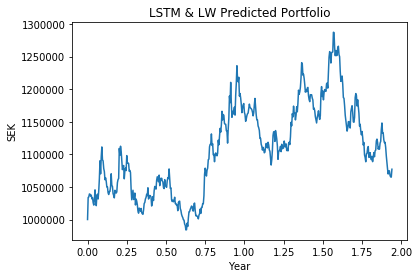

In [17]:
R_lstm2018_20 = pd.read_pickle('./pickle_hyper/R_lstm_2018_2020.pkl').to_numpy()

totValueLSTM_LW, turnoverLSTM_LW, R_Plstm_lw, w = loop_optimization(R_lstm2018_20,
                                                                 Ledoit_Wolf,
                                                                 SigmaHyper = True,
                                                                 gamma = 8)

plot_n_printPortfolio(totValueLSTM_LW, turnoverLSTM_LW, R_Plstm_lw, 'LSTM & LW Predicted Portfolio', w)

In [20]:
plotLSTM_LW = pd.DataFrame(totValueLSTM_LW)
plotLSTM_SCM = pd.DataFrame(totValueLSTM_SCM)
plotSMA_SCM = pd.DataFrame(totValueSMA_SCM)


plotLSTM_LW.to_pickle('./pickle_graphs/totValueLSTM_LW.pkl')
plotLSTM_SCM.to_pickle('./pickle_graphs/totValueLSTM_SCM.pkl')
plotSMA_SCM.to_pickle('./pickle_graphs/totValueSMA_SCM.pkl')